# Implementation of "Graph Sparsification by Effective Resistances" by Spielman and Srivastava

## See:
@article{DBLP:journals/corr/abs-0803-0929,
  author    = {Daniel A. Spielman and
               Nikhil Srivastava},
  title     = {Graph Sparsification by Effective Resistances},
  journal   = {CoRR},
  volume    = {abs/0803.0929},
  year      = {2008},
  url       = {http://arxiv.org/abs/0803.0929},
  archivePrefix = {arXiv},
  eprint    = {0803.0929},
  timestamp = {Mon, 13 Aug 2018 16:46:14 +0200},
  biburl    = {https://dblp.org/rec/bib/journals/corr/abs-0803-0929},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}

This implementation was done for the seminar "Graph Sparsification" at TUM.

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
def construct_matrices(A):
    """ Enumerates the edges in the graph and constructs the matrices neccessary for the algorithm.
    
    Parameters:
    -----------
    A : sp.csr_matrix, shape [N, N]
        The graph adjacency matrix.
    
    Returns:
    --------
    L : sp.csr_matrix, shape [N, N]
        The graph laplacian, unnormalized.
    W_sqrt : sp.coo_matrix, shape [e, e]
        Diagonal matrix containing the square root of weights of each edge.
    B : sp.coo_matrix, shape [e, N]
        Signed vertex incidence matrix.
    edges : tuple
        A tuple of lists containing the row and column indices of the edges.
    """
    L = sp.csgraph.laplacian(A)
    rows, cols = A.nonzero()
    weights = np.sqrt(np.array(A[rows, cols].tolist()))
    W_sqrt = sp.diags(weights, [0])
    # Construct signed edge incidence matrix
    num_vertices = A.shape[0]
    num_edges = W_sqrt.shape[0]
    assert(num_edges == len(rows) and num_edges == len(cols))
    B = sp.coo_matrix((
        ([1] * num_edges) + ([-1] * num_edges),
        (list(range(num_edges)) * 2, list(rows) + list(cols))
    ), shape=[num_edges, num_vertices])
    return L.tocsr(), W_sqrt, B, (rows, cols)

In [23]:
def compute_Z(L, W_sqrt, B, epsilon=1e-1, eta=1e-3, max_iters=1000, convergence_after = 10,
                                    tolerance=1e-2, log_every=10, compute_exact_loss=False):
    """ Computes the Z matrix using gradient descent.
    
    Parameters:
    -----------
    L : sp.csr_matrix, shape [N, N]
        The graph laplacian, unnormalized.
    W_sqrt : sp.coo_matrix, shape [e, e]
        Diagonal matrix containing the square root of weights of each edge.
    B : sp.coo_matrix, shape [e, N]
        Signed vertex incidence matrix.
    epsilon : float
        Tolerance for deviations w.r.t. spectral norm of the sparsifier. Smaller epsilon lead to a higher
        dimensionality of the Z matrix.
    eta : float
        Step size for the gradient descent.
    max_iters : int
        Maximum number of iterations.
    convergence_after : int
        If the loss did not decrease significantly for this amount of iterations, the gradient descent will abort.
    tolerance : float
        The minimum amount of energy decrease that is expected for iterations. If for a certain number of iterations
        no overall energy decrease is detected, the gradient descent will abort.
    log_every : int
        Log the loss after each log_every iterations.
    compute_exact_loss : bool
        Only for debugging. If set it computes the actual pseudo inverse without down-projection and checks if
        the pairwise distances in Z's columns are the same with respect to the forbenius norm.
        
    Returns:
    --------
    Z : ndarray, shape [k, N]
        Matrix from which to efficiently compute approximate resistances.
    """
    k = int(np.ceil(np.log(B.shape[1] / epsilon**2)))
    # Compute the random projection matrix
    Q = (2 * np.random.randint(2, size=(k, B.shape[0])) - 1).astype(np.float)
    Q *= 1 / np.sqrt(k)
    Y = W_sqrt.dot(B).tocsr()
    Y_red = sp.csr_matrix.dot(Q, Y)
    
    if compute_exact_loss:
        # Use exact effective resistances to track actual similarity of the pairwise distances
        L_inv = np.linalg.pinv(L.todense())
        Z_gnd = sp.csr_matrix.dot(Y, L_inv)
        pairwise_dist_gnd = Z_gnd.T.dot(Z_gnd)
    
    # Use gradient descent to solve for Z
    Z = np.random.randn(k, L.shape[1])
    best_loss = np.inf
    best_iter = np.inf
    for it in range(max_iters):
        residual = Y_red - sp.csr_matrix.dot(Z, L)
        loss = np.linalg.norm(residual)
        if it % log_every == 0: 
            print(f'Loss before iteration {it}: {loss}')
            if compute_exact_loss:
                pairwise_dist = Z.T.dot(Z)
                exact_loss = np.linalg.norm(pairwise_dist - pairwise_dist_gnd)
                print(f'Loss w.r.t. exact pairwise distances {exact_loss}')
                
        if loss + tolerance < best_loss:
            best_loss = loss
            best_iter = it
        elif it > best_iter + convergence_after:
            # No improvement for 10 iterations
            print(f'Convergence after {it - 1} iterations.')
            break
        
        Z += eta * L.dot(residual.T).T
    return Z
    

In [4]:
def compute_effective_resistances(Z, edges):
    """ Computes the effective resistance for each edge in the graph.
    
    Paramters:
    ----------
    Z : ndarray, shape [k, N]
        Matrix from which to efficiently compute approximate effective resistances.
    edges : tuple
        A tuple of lists indicating the row and column indices of edges.
        
    Returns:
    --------
    R : ndarray, shape [e]
        Effective resistances for each edge.
    """
    rows, cols = edges
    assert(len(rows) == len(cols))
    R = []
    # Compute pairwise distances
    for i, j in zip(rows, cols):
        R.append(np.linalg.norm(Z[:, i] - Z[:, j]) ** 2)
    return np.array(R)

In [5]:
def sparsify(A, q, R, edges):
    """ Spamples a sparsifier of the graph represented by an adjacency matrix.
    
    Paramters:
    ----------
    A : sp.csr_matrix
        The adjacency matrix of the graph.
    q : int
        The number of samples for the sparsifier.
    R : ndarray, shape [e]
        Effective resistances (approximate) for each edge.
    edges : tuple
        A tuple of lists indicating the row and column indices of edges.
        
    Returns:
    --------
    B : sp.csr_matrix
        The adjacency matrix of the sparsified graph with at most q edges.
    """
    rows, cols = edges
    weights = np.array(A[rows, cols].tolist())[0, :]
    probs = weights * R
    probs /= sum(probs)
    B = sp.lil_matrix(A.shape)
    sampled = np.random.choice(probs.shape[0], q, p=probs)
    for idx in sampled:
        i, j = rows[idx], cols[idx]
        B[i, j] += weights[idx] / q / probs[idx]
    return B.tocsr()
    

In [6]:
def visualize_graph(A):
    rows, cols = A.nonzero()
    edges = list(zip(rows.tolist(), cols.tolist()))
    gr = nx.Graph()
    gr.add_edges_from(edges)
    graph_pos=nx.random_layout(gr)
    nx.draw_networkx_nodes(gr, graph_pos)
    nx.draw_networkx_edges(gr, graph_pos)
    weights = A[rows, cols].tolist()[0]
    nx.draw_networkx_edge_labels(gr, graph_pos, edge_labels=dict(zip(edges, weights)))
    plt.show()


In [7]:
# Create an artificial small graph for testing
# Construct a random adjacency matrix for testing
np.random.seed(1337)
n = 250
m = n * n // 8
A = sp.coo_matrix((np.abs(np.random.randn(m)), (np.random.randint(n, size=m), np.random.randint(n, size=m))), shape=[n, n])
A = A.tocsr()
A = A + A.T
m = A.nnz

In [25]:
epsilon = 1e-2
L, W_sqrt, B, edges = construct_matrices(A)
# Use an approximation
Z = compute_Z(L, W_sqrt, B, epsilon=epsilon, log_every=100, max_iters=10000, convergence_after=50, eta=1e-5, tolerance=1e-4, compute_exact_loss=False)
# Use exact effective resistances
#L_inv = np.linalg.pinv(L.todense())
#Y = W_sqrt.dot(B).tocsr()
#Z_true = sp.csr_matrix.dot(Y, L_inv)
R = compute_effective_resistances(Z, edges)

Loss before iteration 0: 3023.9445743078722
Loss before iteration 100: 354.3271185430482
Loss before iteration 200: 86.92449535500961
Loss before iteration 300: 26.011635935052496
Loss before iteration 400: 8.533384829364051
Loss before iteration 500: 2.949377549497851
Loss before iteration 600: 1.0533882431343633
Loss before iteration 700: 0.3845555971929939
Loss before iteration 800: 0.1425409941178386
Loss before iteration 900: 0.053415762461045235
Loss before iteration 1000: 0.020180071914318573
Loss before iteration 1100: 0.007671429293375017
Loss before iteration 1200: 0.0029306649433674023
Loss before iteration 1300: 0.0011240819398429976
Loss before iteration 1400: 0.00043260307746471123
Loss before iteration 1500: 0.00016696839586614897
Convergence after 1553 iterations.


In [9]:
# Uncomment only if A has few edges
# visualize_graph(A)

/usr/local/lib/python3.6/dist-packages/networkx-2.1-py3.6.egg/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


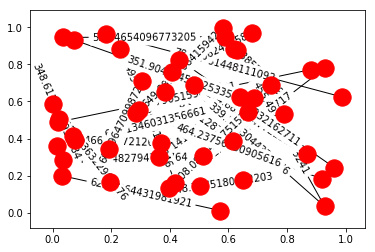

In [10]:
visualize_graph(sparsify(A, 25, R, edges))

In [11]:
def spectral_closeness(L_A, L_X, samples=1000):
    """ Checks the spectral closeness for random vectors.
    
    Parameters:
    -----------
    L_A : sp.csr_matrix
        Laplacian of the original graph.
    L_A : sp.csr_matrix
        Laplacian of the sparsifier.
    samples : int
        The number of random vectors to sample.
        
    Returns:
    --------
    closeness : ndarray, [samples]
        The closeness of the spectral forms w.r.t. to each sample.
    """
    results = []
    for _ in range(samples):
        x = np.random.rand(L_A.shape[0])
        energy = sp.csr_matrix.dot(x.T, L_A).dot(x)
        energy_approx = sp.csr_matrix.dot(x.T, L_X).dot(x)
        results.append(np.abs((energy_approx / energy) - 1))
    return np.array(results)
    

In [12]:
def random_sparsifier(A, q, edges):
    rows, cols = edges
    weights = np.array(A[rows, cols].tolist())[0, :]
    B = sp.lil_matrix(A.shape)
    sampled = np.random.choice(len(rows), q, replace=False)
    for idx in sampled:
        i, j = rows[idx], cols[idx]
        B[i, j] += weights[idx]
    return B.tocsr()
    

1.2% of samples were positive for the paper sparsifier.
0.0% of samples were positive for the random sparsifier.
1.6% of samples were positive for the uniform resistance sparsifier.


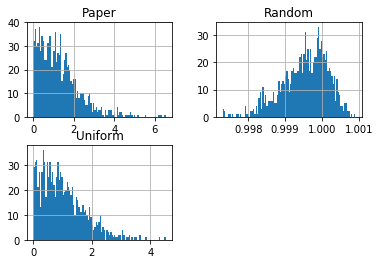

3.3000000000000003% of samples were positive for the paper sparsifier.
0.0% of samples were positive for the random sparsifier.
2.5% of samples were positive for the uniform resistance sparsifier.


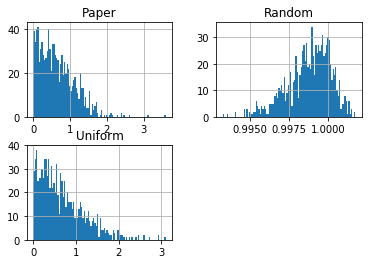

3.2% of samples were positive for the paper sparsifier.
0.0% of samples were positive for the random sparsifier.
4.7% of samples were positive for the uniform resistance sparsifier.


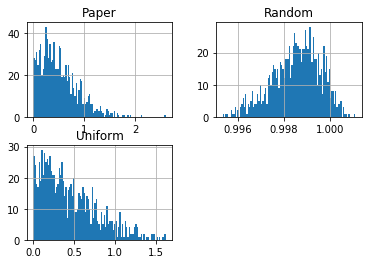

6.2% of samples were positive for the paper sparsifier.
0.0% of samples were positive for the random sparsifier.
6.9% of samples were positive for the uniform resistance sparsifier.


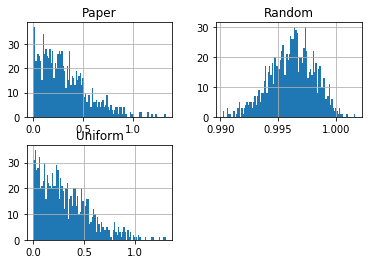

7.3999999999999995% of samples were positive for the paper sparsifier.
0.0% of samples were positive for the random sparsifier.
8.200000000000001% of samples were positive for the uniform resistance sparsifier.


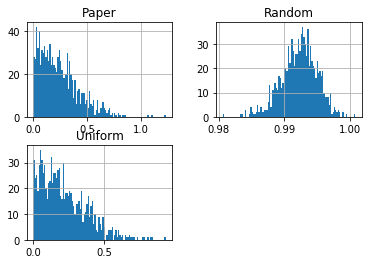

17.5% of samples were positive for the paper sparsifier.
0.0% of samples were positive for the random sparsifier.
18.3% of samples were positive for the uniform resistance sparsifier.


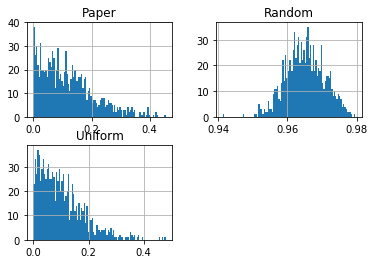

In [15]:
# Check the spectral closeness for different types of sparsifiers
alpha = 3.0
for q in (5, 10, 25, 50, 100, 500):
    B = sparsify(A, q, R, edges)
    B_r = random_sparsifier(A, q, edges)
    B_u = sparsify(A, q, np.ones(R.shape), edges)
    L_B = sp.csgraph.laplacian(B)
    L_B_r = sp.csgraph.laplacian(B_r)
    L_B_u = sp.csgraph.laplacian(B_u)
    scores_paper = spectral_closeness(L, L_B)
    scores_random = spectral_closeness(L, L_B_r)
    scores_uniform = spectral_closeness(L, L_B_u)
    rate_paper = np.sum((scores_paper <= alpha * epsilon).astype(np.int)) / scores_paper.shape[0]  * 100
    rate_random = np.sum((scores_random <= alpha * epsilon).astype(np.int)) / scores_paper.shape[0] * 100
    rate_uniform = np.sum((scores_uniform <= alpha * epsilon).astype(np.int)) / scores_paper.shape[0] * 100
    print(f'{rate_paper}% of samples were positive for the paper sparsifier.')
    print(f'{rate_random}% of samples were positive for the random sparsifier.')
    print(f'{rate_uniform}% of samples were positive for the uniform resistance sparsifier.')
    
    pd.DataFrame({'Paper' : scores_paper, 'Random' : scores_random, 'Uniform' : scores_uniform}).hist(bins=100)
    plt.show()


In [16]:
np.mean(R), np.std(R)

(0.08052361653988369, 0.030900925289906508)